In [20]:
import torch 
from torch import nn 
import pandas as pd
from torch import optim 
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np 
import random 
import timeit
from tqdm import tqdm
from torchvision.transforms import functional as TF   #  <-- add this line
from PIL import Image

### ViT Architecture from the 16x16 words paper

![vit_architecture](ViT_architecture.png)
 

# Hyperparameters

In [21]:
import random
import numpy as np
import torch

# Training Hyperparameters
RANDOM_SEED = 42
EPOCHS = 1
BATCH_SIZE = 256 #change to 256 if memory cant handle 512
LEARNING_RATE = 1e-4
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)

# Dataset Parameters
NUM_CLASSES = 10
IN_CHANNELS = 1


# Data Grids Parameters
GRID_SIZE    = 4                    # 4×4 cells
CELL_PIX     = 14
CANVAS_PIX   = GRID_SIZE * CELL_PIX 
IMAGE_SIZE = CANVAS_PIX

# Vision Transformer (ViT) Architecture Parameters
PATCH_SIZE = 4
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
EMBED_DIM = 64
NUM_HEADS = 4
DROPOUT = 0.001
HIDDEN_DIM = 128
ACTIVATION = "gelu"
NUM_ENCODER = 3


# Setup & Initialization
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True # Optional settings for reproducibility
# torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {device}")
print(f"Number of patches: {NUM_PATCHES}") 

Using device: cpu
Number of patches: 196


# Patch Embedding

In [22]:
# Creating CLS Tokens and merging with Positional Embeddings 

#function that divides images into patches
class PatchEmbedding(nn.Module):
    def __init__(self, embedding_dim, patch_size, num_patches, dropout, in_channels): 
        super().__init__()
        
        self.patcher = nn.Sequential(
            # all Conv2d does is divide our image into patch sizes
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embedding_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ), 
            nn.Flatten(start_dim=2)) 
       
        self.position_embedding = nn.Parameter(torch.randn(size=(1,num_patches,embedding_dim)), requires_grad=True)  #Positional Embedding
        self.dropout = nn.Dropout(dropout)
    

        
        
        
    def forward(self, x): 

        x = self.patcher(x).permute(0,2,1) # first patch x through patcher -> where nn.Conv2d: splits x into patches and embeds them, nn.Flatten(start_dim=2) converts into 1D sequence
        x = self.position_embedding + x #add posi
        x = self.dropout(x)
        return x


# #always test model after you define it    
# model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)  
# x = torch.randn(512, 1, 56, 56).to(device)   #create dummy image of batch size 512, channels 1, and dimensions 28x28 
# print(model(x).shape) #expect (512, 50, 16) where batch size 512, 50 is number of tokens we feed transformer (correct because we have 49 patches + CLS token), 16 is size of patches (embedding dimension)

# Encoder 

In [23]:
import math
# === Helper activation ========================================================
class NewGELUActivation(nn.Module):                       # same formula as HF
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0)) * (x + 0.044715 * torch.pow(x, 3))
        ))

# === 1. One attention head ====================================================
class AttentionHead(nn.Module):
    def __init__(self, hidden_size: int, head_dim: int, dropout: float,
                 bias: bool = True):
        super().__init__()
        self.head_dim = head_dim
        self.q_proj = nn.Linear(hidden_size, head_dim, bias=bias)
        self.k_proj = nn.Linear(hidden_size, head_dim, bias=bias)
        self.v_proj = nn.Linear(hidden_size, head_dim, bias=bias)
        self.drop = nn.Dropout(dropout)

    def forward(self, q_in, k_in, v_in, mask=None):                                 # x: (B, S, D)
        # q, k, v = self.q(x), self.k(x), self.v(x)         # (B,S,d_h) each
        q = self.q_proj(q_in) # (B, Seq_q, d_h)
        k = self.k_proj(k_in) # (B, Seq_k, d_h)
        v = self.v_proj(v_in) # (B, Seq_v, d_h)
        
        scores = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        
        if mask is not None:
            scores = scores.masked_fill(~mask, float("-inf"))
            
        attn = scores.softmax(dim=-1)
        attn = self.drop(attn)            # (B,S,S)
        context = attn @ v 
        return context                                 # (B,S,d_h)

# === 2. Multi-head self-attention =============================================
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size: int = EMBED_DIM,
                 num_heads: int = NUM_HEADS,
                 dropout: float = DROPOUT,
                 qkv_bias: bool = True):
        super().__init__()
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        head_dim = hidden_size // num_heads
        self.heads = nn.ModuleList([
            AttentionHead(hidden_size, head_dim, dropout, qkv_bias)
            for _ in range(num_heads)
        ])
        self.out_proj = nn.Linear(hidden_size, hidden_size)
        self.drop = nn.Dropout(dropout)

    def forward(self, q, k=None, v=None, mask=None):          
        """
        q : (B, Seq_q, D)
        k : (B, Seq_k, D)   defaults to q if None
        v : (B, Seq_k, D)   defaults to k if None
        mask : (1, 1, Seq_q, Seq_k) or None
        """
        k = q if k is None else k
        v = q if v is None else v

        # run every head, collect their (B, Seq_q, d_h) outputs
        head_outputs = [
            head(q, k, v, mask) for head in self.heads
        ]                                 # list length H
        concat = torch.cat(head_outputs, dim=-1)  # (B, Seq_q, D)

        out = self.out_proj(concat)  # cache the projection
        # print("      [MultiHeadAttention] q:", q.shape)
        # print("      [MultiHeadAttention] k:", k.shape)
        # print("      [MultiHeadAttention] v:", v.shape)
        # print("      [MultiHeadAttention] output:", out.shape)

        return self.drop(out)

# === 3. Position-wise feed-forward (MLP) ======================================
class MLP(nn.Module):
    def __init__(self, hidden_size: int = EMBED_DIM,
                 intermediate_size: int = HIDDEN_DIM * 4,
                 dropout: float = DROPOUT):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_size, intermediate_size),
            NewGELUActivation(),
            nn.Linear(intermediate_size, hidden_size),
            nn.Dropout(dropout)
        )
    def forward(self, x):                                 # (B,S,D) -> (B,S,D)
        return self.net(x)

# === 4. Transformer block =====================================================
class Block(nn.Module):
    def __init__(self, hidden_size: int = EMBED_DIM,
                 num_heads: int = NUM_HEADS,
                 mlp_ratio: int = 4,
                 dropout: float = DROPOUT):
        super().__init__()
        self.ln1 = nn.LayerNorm(hidden_size)
        self.attn = MultiHeadAttention(hidden_size, num_heads, dropout)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.mlp = MLP(hidden_size, hidden_size * mlp_ratio, dropout)

    def forward(self, x):                                 # (B,S,D)
        x = x + self.attn(self.ln1(x))                    # SA + residual
        x = x + self.mlp(self.ln2(x))                     # MLP + residual
        return x                                          # (B,S,D)

# === 5. Encoder = N stacked blocks ============================================
class Encoder(nn.Module):
    def __init__(self, depth: int = NUM_ENCODER,
                 hidden_size: int = EMBED_DIM,
                 num_heads: int = NUM_HEADS,
                 dropout: float = DROPOUT):
        super().__init__()
        self.blocks = nn.ModuleList([
            Block(hidden_size, num_heads, dropout=dropout)
            for _ in range(depth)
        ])
        self.ln_final = nn.LayerNorm(hidden_size)

    def forward(self, x):                                 # (B,S,D)
        for blk in self.blocks:
            x = blk(x)
        return self.ln_final(x)                           # final norm


# Decoder

In [24]:
# ─────────────────────────────────────────────────────────────────────────────
#  Synthetic 2×2–grid dataset (Stage-1 of our encoder-decoder project)
#  Canvas: 56×56   PatchSize: 4  → 14×14 = 196 patch tokens
# ─────────────────────────────────────────────────────────────────────────────
VOCAB = {str(i): i for i in range(10)}
VOCAB['<start>']  = 10
VOCAB['<finish>'] = 11
VOCAB['<pad>']    = 12
PAD_IDX      = VOCAB['<pad>']
MAX_DECODER_LEN  = 128                    #  some big number
VOCAB_INV = {v: k for k, v in VOCAB.items()}

In [25]:
#causal mask 
def causal_mask(seq_len: int, device=None):
    idx = torch.arange(seq_len, device=device)
    mask = idx[:, None] >= idx[None, :]          # (T, T) bool
    return mask[None, :, :]                      # (1, T, T)

class DecoderBlock(nn.Module):
    def __init__(self,
                 hidden_size: int = EMBED_DIM,
                 num_heads: int = NUM_HEADS,
                 dropout: float = DROPOUT):
        super().__init__()
        self.ln1 = nn.LayerNorm(hidden_size)
        self.self_attn = MultiHeadAttention(hidden_size, num_heads, dropout)

        self.ln2 = nn.LayerNorm(hidden_size)
        self.cross_attn = MultiHeadAttention(hidden_size, num_heads, dropout)

        self.ln3 = nn.LayerNorm(hidden_size)
        self.mlp = MLP(hidden_size, hidden_size * 4, dropout)

    def forward(self, x, enc_out, mask):
        """
        x       : (B, T, D)   decoder input so far
        enc_out : (B, S, D)   encoder memory
        mask    : (1, 1, T, T) causal mask
        """
        # 1. masked self-attention
        qkv_in = self.ln1(x)
        x = x + self.self_attn(qkv_in, qkv_in, qkv_in, mask)

        # 2. encoder–decoder cross-attention
        q = self.ln2(x)
        k = v = enc_out                        # same tensor for key and value
        x = x + self.cross_attn(q, k, v)       # no mask here

        # 3. feed-forward
        x = x + self.mlp(self.ln3(x))
        return x


class DigitDecoder(nn.Module):
    def __init__(self, 
                 hidden_size: int = EMBED_DIM,
                 num_heads: int = NUM_HEADS,
                 dropout: float = DROPOUT,
                 depth: int = 3, #number of decoder blocks stacked sequentially
                 vocab_size: int = len(VOCAB)
                 ):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, hidden_size) 
        self.pos_embed = nn.Parameter(torch.randn(1, MAX_DECODER_LEN, hidden_size))
        
        self.blocks = nn.ModuleList([
            DecoderBlock(hidden_size, num_heads, dropout)
            for _ in range(depth)
        ])
        self.ln_final = nn.LayerNorm(hidden_size)
        self.head = nn.Linear(hidden_size, vocab_size)
        
        
    def forward(self, targets, enc_out):
        """
        targets : (B, T) integer ids including <start> at index 0
        enc_out : (B, S, D)
        returns
        logits  : (B, T-1, vocab) – predictions for d1, d2, …, <finish>
        """

        B, T = targets.size()
        
        
        token_inputs = targets[:, :-1] #(B, T-1)
        # print("  token_inputs:", token_inputs.shape)
        x = self.token_embed(token_inputs) #(B, T-1, D)
        # print("  embedded x:", x.shape)
        x = x + self.pos_embed[:, :x.size(1), :] 
        # print("    [DecoderBlock] x input :", x.shape)
        
        mask = causal_mask(T-1, x.device)        # (1,1,T-1,T-1)


        #run through blocks 
        for blk in self.blocks: 
            x = blk(x, enc_out, mask) 
        
        x = self.ln_final(x)
        logits = self.head(x)
        
        # print("  logits before return:", logits.shape)
        return logits 

    

# Full Encoder-Decoder Model

In [26]:
class GridTranscriber(nn.Module):
    def __init__(self): 
        super().__init__()
        
        #reuse PatchEmbedding and Encoder 
        self.embed = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS)
        self.encoder = Encoder(NUM_ENCODER, EMBED_DIM, NUM_HEADS, DROPOUT)
        self.decoder = DigitDecoder(EMBED_DIM, NUM_HEADS, depth = 3)
        
    def forward(self, images, targets): 
        # enc_seq = self.encoder(self.embed(images))
        # logits = self.decoder(targets, enc_seq)
        # return logits 
        # print("INPUT images shape:", images.shape)
        x = self.embed(images)
        # print("AFTER PatchEmbedding:", x.shape)
        x = self.encoder(x)
        # print("AFTER Encoder:", x.shape)
        logits = self.decoder(targets, x)
        # print("AFTER Decoder:", logits.shape)
        return logits
    

In [27]:
B = 2
dummy_img = torch.randn(B, 1, 56, 56)          # batch of fake canvases
dummy_tgt = torch.randint(0, 10, (B, 5))       # random digits 0-9
model = GridTranscriber()
out = model(dummy_img, dummy_tgt)
# print("logits shape :", out.shape)             # should be (2, 6, 13)


# Dataset

In [28]:
#Download MNIST dataset 

transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)



In [29]:
import os

grid_transforms = transforms.Compose([
    transforms.ToTensor(),                  # uint8 → 0-1
    transforms.Normalize([0.5], [0.5])      # centre to −1..1
])

class GridMNIST(Dataset):
    def __init__(self, base_images, base_labels,
                 epoch_size=60_000, rng=None):
        self.base_images = base_images          # (N,28,28) uint8
        self.base_labels = base_labels          # (N,)
        self.epoch_size  = epoch_size
        self.rng = np.random.default_rng(rng)

        # indices per digit for fast balanced sampling
        self.per_digit = {d: np.where(base_labels == d)[0] for d in range(10)}


    def __len__(self):
        return self.epoch_size

    def _random_cells(self):
        n = self.rng.integers(1, 17)
        return self.rng.choice(16, size=n, replace=False)

    def __getitem__(self, idx):
        cell_ids = self._random_cells()

        canvas = np.zeros((CANVAS_PIX, CANVAS_PIX), dtype=np.uint8)
        digits = []

        for cell in cell_ids:
            d = int(self.rng.integers(0, 10))
            img_idx = self.rng.choice(self.per_digit[d])
            digit_img = self.base_images[img_idx]
            
            # ↓↓ new: shrink 28×28 → 14×14 so 2×2 fits in 28×28
            digit_img = TF.resize(Image.fromarray(digit_img), 14)
            digit_img = np.array(digit_img, dtype=np.uint8)

            row, col = divmod(cell, GRID_SIZE)
            top, left = row*CELL_PIX, col*CELL_PIX
            canvas[top:top+CELL_PIX, left:left+CELL_PIX] = digit_img

            digits.append(d)

        #build target sequence 
        odds  = sorted([d for d in digits if d % 2 == 1])
        evens = sorted([d for d in digits if d % 2 == 0], reverse=True)
        seq   = [VOCAB['<start>']] + odds + evens + [VOCAB['<finish>']]

        return {
            'image'  : grid_transforms(canvas),          # (1,56,56) float
            'target' : torch.tensor(seq, dtype=torch.long),  # (6,)
        }
    
# Collate function to add padding to the targets 
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    images  = torch.stack([item['image'] for item in batch])  # shape: (B, 1, 56, 56)
    targets = [item['target'] for item in batch]              # list of length-B tensors
    padded_targets = pad_sequence(targets, batch_first=True, padding_value=PAD_IDX)  # (B, T_max)
    return {'image': images, 'target': padded_targets}



# ─── build train / val / test loaders ───────────────────────────────────────
train_grid = GridMNIST(train_dataset.data.numpy(),
                       train_dataset.targets.numpy(),
                       epoch_size=60_000, rng=RANDOM_SEED)

val_grid   = GridMNIST(test_dataset.data.numpy(),   # we reuse MNIST test set
                       test_dataset.targets.numpy(),
                       epoch_size=10_000, rng=RANDOM_SEED+1)

test_grid  = GridMNIST(test_dataset.data.numpy(),
                       test_dataset.targets.numpy(),
                       epoch_size=10_000, rng=RANDOM_SEED+2)

# ——————————————————————————————————————————————————————————————
# Decide how many CPU cores to devote to data loading.
# Four to eight usually keeps the GPU fed without wasting resources.
# ——————————————————————————————————————————————————————————————
NUM_WORKERS = min(8, os.cpu_count())        # 4-8 is a good starting range

loader_kwargs = dict(
    batch_size      = BATCH_SIZE,
    num_workers     = NUM_WORKERS,          # <- key addition
    pin_memory      = True,                 # speeds up host-to-device copy
    persistent_workers = True,              # keeps workers alive across epochs
    prefetch_factor = 4                     # each worker holds 4 batches ready
)

train_dataloader = DataLoader(
    train_grid,
    shuffle=True,
    collate_fn=collate_batch,       
    **loader_kwargs
)

val_dataloader = DataLoader(
    val_grid,
    shuffle=False,
    collate_fn=collate_batch,           
    **loader_kwargs
)

test_dataloader = DataLoader(
    test_grid,
    shuffle=False,
    collate_fn=collate_batch,      
    **loader_kwargs
)



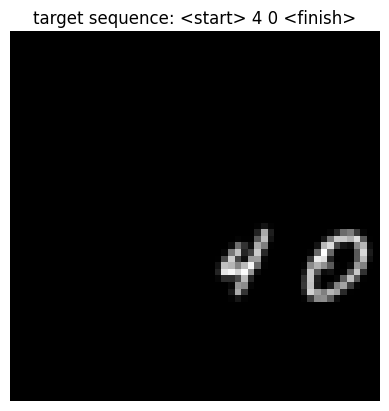

In [30]:
import multiprocessing as mp
mp.set_start_method("fork", force=True)

# quick sanity-check: show a random training sample
sample = next(iter(train_dataloader))
img_grid = sample['image'][0].squeeze().cpu()   # (56,56)
target   = sample['target'][0].tolist()
seq_txt = ' '.join([VOCAB_INV[t] for t in target   # after padding
                    if t not in (PAD_IDX,)])

plt.imshow(img_grid, cmap='gray')
plt.title(f"target sequence: {seq_txt}")
plt.axis('off')
plt.show()


In [31]:
#free up space in GPU memory 
torch.cuda.empty_cache()

# Training Loop for Encoder-Decoder Model

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 0.  Optimizer & Loss
# ─────────────────────────────────────────────────────────────────────────────
criterion = nn.CrossEntropyLoss()          # PAD will be masked manually
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=ADAM_WEIGHT_DECAY,
    betas=ADAM_BETAS
)

# ─────────────────────────────────────────────────────────────────────────────
# 1.  Exact‑match metric (ignores PAD)
# ─────────────────────────────────────────────────────────────────────────────
def sequence_exact_match(pred_ids, gold_ids):
    ok = (pred_ids == gold_ids) | (gold_ids == PAD_IDX)
    return ok.all(dim=1).float().mean().item()

# ─────────────────────────────────────────────────────────────────────────────
# NEW: Print target token distribution
# ─────────────────────────────────────────────────────────────────────────────
print("\n--- Target Token Distribution (Training Set) ---")
all_tokens = torch.cat([sample["target"] for sample in train_grid]) # Assumes train_grid is loaded
counts = torch.bincount(all_tokens, minlength=len(VOCAB)) # Assumes VOCAB is defined
for i, c in enumerate(counts):
    print(f"{VOCAB_INV[i]:>8}: {c}") # Assumes VOCAB_INV is defined
print("------------------------------------------------\n")

# ─────────────────────────────────────────────────────────────────────────────
# 2.  Train / Validation loop
# ─────────────────────────────────────────────────────────────────────────────
for epoch in range(EPOCHS):
    # -------- TRAIN ------------------------------------------------------
    model.train()
    tr_loss = tr_em = tr_tok = 0.0

    for batch in tqdm(train_dataloader, desc=f"train {epoch+1}/{EPOCHS}"):
        imgs    = batch["image"].to(device)     # (B, 1, H, W)
        targets = batch["target"].to(device)    # (B, T)  <start>…<finish>

        dec_in   = targets                      # (B, T)
        gold_out = targets[:, 1:]               # (B, T‑1)

        logits   = model(imgs, dec_in)          # (B, T‑1, V)
        assert logits.shape[:2] == gold_out.shape

        mask            = gold_out != PAD_IDX                     # (B, T‑1)
        logits_flat     = logits.reshape(-1, len(VOCAB))          # (B*T, V)
        gold_flat       = gold_out.reshape(-1)                    # (B*T,)

        logits_masked   = logits_flat[mask.reshape(-1)]           # (~P, V)
        gold_masked     = gold_flat[mask.reshape(-1)]             # (~P,)

        loss = criterion(logits_masked, gold_masked)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds    = logits.argmax(dim=-1)

        # ─── Token Accuracy (excluding PAD) ──────────────────────────────
        tok_correct = (preds == gold_out) & mask
        tok_acc = tok_correct.sum().item() / mask.sum().item()

        tr_loss += loss.item()
        tr_em   += sequence_exact_match(preds, gold_out)
        tr_tok  += tok_acc

    tr_loss /= len(train_dataloader)
    tr_em   /= len(train_dataloader)
    tr_tok  /= len(train_dataloader)

    # -------- VALIDATION -------------------------------------------------
    model.eval()
    val_loss = val_em = val_tok = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            imgs    = batch["image"].to(device)
            targets = batch["target"].to(device)

            dec_in   = targets
            gold_out = targets[:, 1:]

            logits   = model(imgs, dec_in)
            assert logits.shape[:2] == gold_out.shape

            mask            = gold_out != PAD_IDX
            logits_flat     = logits.reshape(-1, len(VOCAB))
            gold_flat       = gold_out.reshape(-1)

            logits_masked   = logits_flat[mask.reshape(-1)]
            gold_masked     = gold_flat[mask.reshape(-1)]

            loss = criterion(logits_masked, gold_masked)

            preds    = logits.argmax(dim=-1)

            # ─── Token Accuracy (excluding PAD) ──────────────────────────
            tok_correct = (preds == gold_out) & mask
            tok_acc = tok_correct.sum().item() / mask.sum().item()

            val_loss += loss.item()
            val_em   += sequence_exact_match(preds, gold_out)
            val_tok  += tok_acc

    val_loss /= len(val_dataloader)
    val_em   /= len(val_dataloader)
    val_tok  /= len(val_dataloader)

    # --- Sanity check: Visualize predictions vs gold for first epoch --- 
    if epoch == 0: 
        # Get the predictions and gold sequences from the *last* validation batch
        # Note: .tolist() moves data from GPU to CPU if needed
        idx = 0  # Index of the sample within the batch to visualize
        if preds.shape[0] > idx: # Check if the batch has at least one sample
            pred_seq = preds[idx].tolist()
            gold_seq = gold_out[idx].tolist()
            # Convert token IDs to strings, filtering out padding
            pred_str = [VOCAB_INV[t] for t in pred_seq if t != PAD_IDX] # Assumes VOCAB_INV and PAD_IDX defined
            gold_str = [VOCAB_INV[t] for t in gold_seq if t != PAD_IDX] # Assumes VOCAB_INV and PAD_IDX defined
            print(f"-- Epoch {epoch+1} Validation Sample {idx} --")
            print(f"PRED ({len(pred_str)} tokens): {' '.join(pred_str)}")
            print(f"GOLD ({len(gold_str)} tokens): {' '.join(gold_str)}")
            print("-------------------------------------")
        else:
            print(f"-- Epoch {epoch+1} Validation: Last batch was empty or smaller than index {idx}, cannot show sample --")

    print(f"Epoch {epoch+1}/{EPOCHS} │ "
          f"train loss {tr_loss:.4f} │ EM {tr_em:.4f} │ tok_acc {tr_tok:.4f} │ "
          f"val loss {val_loss:.4f} │ EM {val_em:.4f} │ tok_acc {val_tok:.4f}")



--- Target Token Distribution (Training Set) ---


In [ ]:
# %% ──────────────────────────────────────────────────────────────────────────
# Inference: greedy decoding on a single test image
import torch
import torch.nn.functional as F

# ---------------------------------------------------------------------------
# 0. Move model to the device you want to run on
device = "cpu"        # ← change to "cuda" if you want GPU decoding
model = model.to(device).eval()      # make sure this is your trained model

# ---------------------------------------------------------------------------
# 1. Grab a single test image  (shape: 1×56×56)  and move to same device
sample      = next(iter(test_dataloader))         # batch dict
test_image  = sample["image"][0].to(device)       # (1,56,56) tensor

# ---------------------------------------------------------------------------
# 2. Minimal tokenizer wrapper around VOCAB / VOCAB_INV dicts
class SimpleTokenizer:
    def __init__(self, vocab, vocab_inv):
        self.token_to_idx = vocab
        self.idx_to_token = vocab_inv

tokenizer = SimpleTokenizer(VOCAB, VOCAB_INV)

# ---------------------------------------------------------------------------
# 3. Point to the patch‑embedding layer (lives in model.embed)
patch_embed_layer = model.embed

# ---------------------------------------------------------------------------
# 4.  Greedy‑decode (function you defined earlier)
def preprocess(image, patch_embed):
    image = image.unsqueeze(0)                # (1,1,H,W)
    return patch_embed(image)                 # (1, seq_len, D)

def decode_token_ids(token_ids, tokenizer):
    return [tokenizer.idx_to_token[i] for i in token_ids]

@torch.no_grad()
def greedy_decode(model, test_image, patch_embed, tokenizer, max_len=10):
    print("Starting greedy decode …")
    model.eval()

    encoder_input  = preprocess(test_image, patch_embed)
    encoder_output = model.encoder(encoder_input)

    start_id   = tokenizer.token_to_idx["<start>"]
    pad_id     = tokenizer.token_to_idx["<pad>"]
    finish_id  = tokenizer.token_to_idx["<finish>"]

    decoder_input = torch.full((1, max_len), pad_id, dtype=torch.long).to(test_image.device)
    decoder_input[0, 0] = start_id

    for t in range(1, max_len):
        if t == 1:
            # DigitDecoder will slice off last token, so we need at least 2
            input_tokens = decoder_input[:, :2]
        else:
            input_tokens = decoder_input[:, :t]

        logits = model.decoder(input_tokens, encoder_output)   # (1,t-1,vocab)
        if logits.shape[1] == 0:
            print("Warning: decoder returned empty logits at step", t)
            break

        next_id = logits[:, -1].argmax(-1)  # (1,)
        decoder_input[0, t] = next_id.item()

        print(f"step {t}: {tokenizer.idx_to_token[next_id.item()]}")
        if next_id.item() == finish_id:
            break

    tokens = decode_token_ids(decoder_input[0].tolist(), tokenizer)
    print("final sequence:", tokens)
    return tokens


# ---------------------------------------------------------------------------
# 5. Run it
generated = greedy_decode(
    model       = model,
    test_image  = test_image,
    patch_embed = patch_embed_layer,
    tokenizer   = tokenizer,
    max_len     = 8        # adjust to your task’s longest sequence
)

print("Generated tokens:", generated)
